# End-to-End ETL Data Pipeline and Exploratory Data Analysing Using Youtube Video Data from Most Popular Music Channels

## 1. Aims, objectives and background
### 1.1. Introduction

Founded in 2005, Youtube has grown to become the second largest search engine in the world (behind Google) that processes more than 3 billion searches per month. [1]. It is, however, generally a myth how the Youtube algorithm works, what makes a video get views and be recommended over another. In fact, YouTube has one of the largest scale and most sophisticated industrial recommendation systems in existence [2]. For new content creators, it is a challenge to understand why a video gets video and others do not. There are many "myths" around the success of a Youtube video [3], for example if the video has more likes or comments, or if the video is of a certain duration. It is also worth experimenting and looking for "trends" in the topics that Youtube channels are covering in a certain niche.

This notebook is the final part of a complete real-time big data project pipeline.It presents detailed exploratory data analysis (EDA) on YouTube video and channel statistics after passing through a multi-stage ETL workflow powered by Big Data technologies.The pipeline begins with data extraction using the YouTube Data API and continues with real-time ingestion through Apache Kafka.PySpark is used to define transformation schemas and process the streamed data, which is then stored in Hadoop Distributed File System (HDFS).Once stored, this notebook loads the cleaned data for analysis using Pandas, Seaborn, and Matplotlib.

This notebook reflects insights derived from a fully-automated, scalable architecture integrating API-based data collection,
streaming with Kafka, distributed processing with Spark, reliable storage with HDFS, and final analytics for business insights.
Therefore, in this project will explore the statistics of around 10 or more most successful music Youtube channel.

### 1.2. Aims and objectives

Within this project, I would like to explore the following:
  
  Getting to know Youtube API and how to obtain video data.
    
    * Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
        - Does the number of likes and comments matter for a video to get more views?
        - Does the video duration matter for views and interaction (likes/ comments)?
        - Does title length matter for views?
        - How many tags do good performing videos have? What are the common tags among these videos?
        - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?
    * Explore the trending topics using NLP techniques
        - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
        - Which questions are being asked in the comment sections in the videos


### 1.3. Steps of the project

    1. Develop a youtube_extractor.py script to Obtain video meta data via Youtube API for the top 10 or more channels in the musics niche
    (this includes several small steps: create a developer key,request data and transform the responses into a usable data format)
    2. Develop a kafka_consumer.py script to receive data,design schema using pyspark and engineer additional features for analysis
    3. Data preprocessing and Exploratory data analysis(EDA)
    4. Conclusions


### Data limitations

The dataset is a real-world dataset and suitable for the research. However, the selection of the top 10 Youtube channels to include in the research is purely based on my knowledge of the channels in data science field and might not be accurate. My definition is "popular" is only based on subscriber count but there are other metrics that could be taken into consideration as well (e.g. views, engagement). The top 10 also seems arbitrary given the plethora of channels on Youtube. There might be smaller channels that might also very interesting to look into, which could be the next step of this project.

### Ethics of data source

According to Youtube API's guide, the usage of Youtube API is free of charge given that your application send requests within a quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " The default quota allocation for each application is 10,000 units per day, and you could request additional quota by completing a form to YouTube API Services if you reach the quota limit.

Since all data requested from Youtube API is public data (which everyone on the Internet can see on Youtube), there is no particular privacy issues as far as I am concerned. In addition, the data is obtained only for research purposes in this case and not for any commercial interests.

In [291]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate
from pyspark.sql import SparkSession

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)


In [292]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/saravananb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/saravananb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Get Channel Statistics

In [293]:
spark = SparkSession.builder \
    .appName("HDFS-Data-Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Read Channel_stats data from HDFS
df = spark.read.format("parquet").load("hdfs://localhost:9000/user/hadoop/youtube_data/channel_stats")

# Remove duplicates using PySpark
df = df.dropDuplicates()

# Convert to Pandas DataFrame for easy analysis
chl_pdf = df.toPandas()

# Show the first 20 rows
chl_pdf.head(10)

,channel_id,channel_name,subscriber_count,views_count,total_videos,playlist_id
0,UCFFbwnve3yF62-tVXkTyHqg,Zee Music Company,116000000,76691023972,13948,UUFFbwnve3yF62-tVXkTyHqg
1,UCVlWr_LN9y80smEMr0KTBOA,Ilaiyaraaja Official,2340000,961328787,1994,UUVlWr_LN9y80smEMr0KTBOA
2,UCn4rEMqKtwBQ6-oEwbd4PcA,Sony Music South,19500000,17118890876,4493,UUn4rEMqKtwBQ6-oEwbd4PcA
3,UCJrDMFOdv1I2k8n9oK_V21w,Tips Official,74400000,46193536450,7613,UUJrDMFOdv1I2k8n9oK_V21w
4,UCAEv0ANkT221wXsTnxFnBsQ,T-Series Tamil,5100000,3388296703,3356,UUAEv0ANkT221wXsTnxFnBsQ
5,UCzee67JnEcuvjErRyWP3GpQ,Saregama Tamil,8940000,4984320742,9266,UUzee67JnEcuvjErRyWP3GpQ
6,UCUgP5pdToi19fWe19NVliFg,TrendMusic,1830000,1006203657,2476,UUUgP5pdToi19fWe19NVliFg
7,UCJrDMFOdv1I2k8n9oK_V21w,Tips Official,74400000,46193536450,7612,UUJrDMFOdv1I2k8n9oK_V21w
8,UCUgP5pdToi19fWe19NVliFg,TrendMusic,1830000,1006484188,2477,UUUgP5pdToi19fWe19NVliFg
9,UCUgP5pdToi19fWe19NVliFg,TrendMusic,1830000,1006484188,2476,UUUgP5pdToi19fWe19NVliFg


In [294]:
chl_pdf.dtypes

channel_id          object
channel_name        object
subscriber_count     int64
views_count          int64
total_videos         int64
playlist_id         object
dtype: object

#### Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

/tmp/ipykernel_5403/1569567502.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


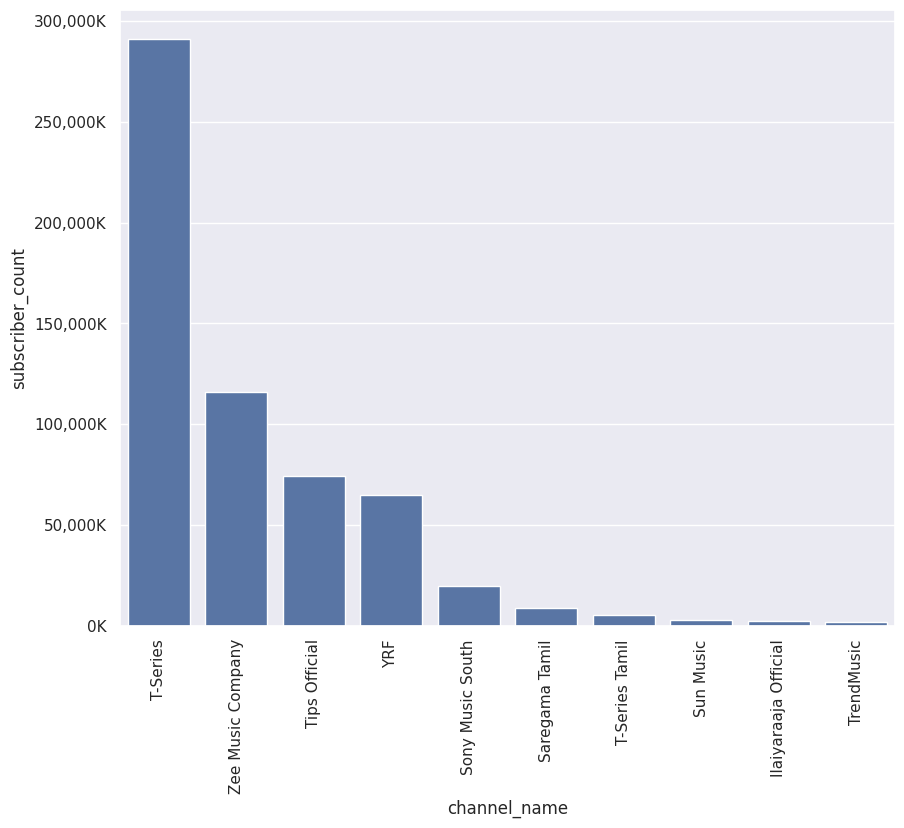

In [295]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channel_name', y='subscriber_count', data=chl_pdf.sort_values('subscriber_count', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

##### Next, we will look at the rank considering the total number of views of the channels. The rank is fairly similar to the subscriber count rank. T-Series and Zee Music Company remain the two most popular channels considering both subscribers and views. Interestingly, some channels have more subscribers but less views and vice versa. For example, Tips Official channel has significantly more subscribers than YRF channel, but slightly less views in total.

/tmp/ipykernel_5403/3316787949.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


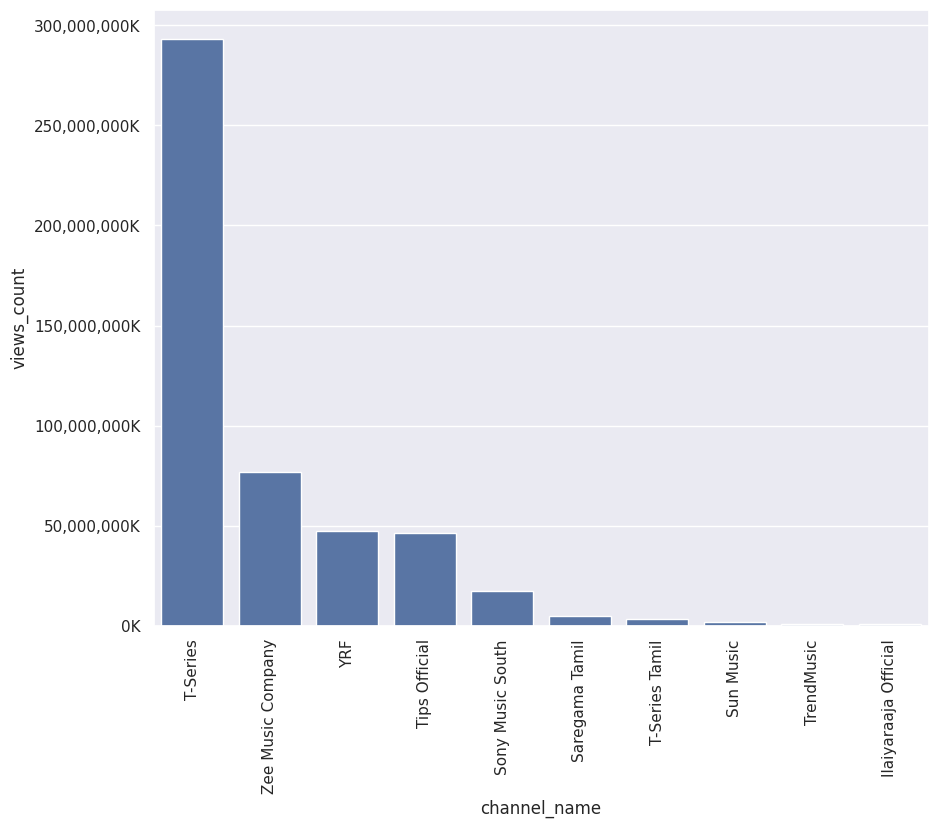

In [296]:
ax = sns.barplot(x='channel_name', y='views_count', data=chl_pdf.sort_values('views_count', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


### Get Video Statistics for all Youtube Music Channels 

In [297]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("HDFS-Data-Analysis") \
    .master("local[*]") \
    .getOrCreate()

# Read Video_stats data from HDFS
df = spark.read.format("parquet").load("hdfs://localhost:9000/user/hadoop/youtube_data/video_stats", header=True, inferSchema=True)

# Convert to Pandas for easy analysis
vid_pdf = df.toPandas()
vid_pdf.head()

,playlist_id,channel_name,video_id,title,description,tags,publish_at,views_count,like_count,comment_count,video_duration,comment,caption,definition
0,UUzee67JnEcuvjErRyWP3GpQ,Saregama Tamil,bo4VVdhmuwY,Podhum Podhum - Audio Song | Kadhale Kadhale |...,"For more latest songs & videos, subscribe 👉 ht...","[Podhum Podhum audio song, Kadhale Kadhale Tam...",2025-04-07T14:30:20Z,3409,66,8,PT3M51S,மிக மிக அருமையான பாடல். திரைப்படம் வெற்றி பெற ...,false,hd
1,UUbTLwN10NoCU4WDzLf1JMOA,Yash Raj Films (YRF),4kIzh5GEymE,माना अपना इश्क़ अधूरा 💔 | #Bulleya | #Sultan | ...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[bulleya song, bulleya full song, bulleya song...",2025-03-15T13:30:03Z,246189,12049,32,PT28S,Script ✅<br>Performance ✅<br>Presentation ✅<br...,false,hd
2,UUbTLwN10NoCU4WDzLf1JMOA,Yash Raj Films (YRF),CKyCHECAGxY,तू बोले तो बन जाऊँ मैं बुल्लेशाह सौदाई | #Bull...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[bulleya song, bulleya full song, bulleya song...",2025-04-08T16:30:05Z,131515,2197,14,PT22S,So decent movie and the songs 💐💌👍,false,hd
3,UUbTLwN10NoCU4WDzLf1JMOA,Yash Raj Films (YRF),T9u6irq1xAg,Kyun doori hai ab darmiyaan | #DekhoNa | #Fana...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[aamir khan, kajol, fanaa, dekho na song, sonu...",2025-03-24T16:30:10Z,53549,1588,8,PT25S,So romantically...❤❤😊 Mujhe mat bhej mere bha...,false,hd
4,UUFFbwnve3yF62-tVXkTyHqg,Zee Music Company,SX2YWi-g8d8,"Chunni - Shaunki Sardar | Babbu Maan, Guru Ran...",👉🏻 SUBSCRIBE to Zee Music Company - https://bi...,"[chunni official music video, chunni leli tere...",2025-04-14T06:30:03Z,2247037,58144,3955,PT3M3S,ਜਦੋਂ ਜਵਾਨੀ ਉਡਾਣ ਭਰਦੀ ਫੇਰ ਪੱਗ ਨਾਲ ਚੁੰਨੀ ਮੈਚ ਕਰਦ...,false,hd


In [298]:
vid_pdf.tail()

,playlist_id,channel_name,video_id,title,description,tags,publish_at,views_count,like_count,comment_count,video_duration,comment,caption,definition
504,UUJrDMFOdv1I2k8n9oK_V21w,Tips Official,Xjk0TU3T0Qc,This song still iconic after all these years #...,,[],2025-04-13T14:30:15Z,95353,780,7,PT28S,❤,false,hd
505,UUJrDMFOdv1I2k8n9oK_V21w,Tips Official,8RpCOhUwSAc,Because one love song wasn’t enough.Peheli Naz...,,[],2025-04-12T14:30:07Z,55774,440,8,PT31S,❤,false,hd
506,UUJrDMFOdv1I2k8n9oK_V21w,Tips Official,RC_vApGeAgI,You haven’t truly lived until life’s made you ...,,[],2025-04-17T14:30:16Z,77,9,0,PT33S,,false,hd
507,UUJrDMFOdv1I2k8n9oK_V21w,Tips Official,CiPoyqIGBM8,#HappyBirthdayAlankritaSahai #hindisong,,[],2025-04-14T14:30:11Z,51228,268,2,PT24S,❤❤❤❤❤❤❤,false,hd
508,UUn4rEMqKtwBQ6-oEwbd4PcA,Sony Music South,IypHSZmiK_Q,"Chaak - AZWIN,JOKER,EFY",,[],2025-04-17T07:29:58Z,31557,82,1,PT31S,❤❤,false,hd


In [299]:
import pandas as pd

# Assuming your DataFrame is named `vid_df`
comments_df = vid_pdf[['video_id', 'comment']]

# If multiple comments exist per video_id, group them into a list
grouped_comments = comments_df.groupby('video_id')['comment'].apply(list).reset_index()

# Optional: Convert list to string (for cleaner CSV)
grouped_comments['comment'] = grouped_comments['comment'].apply(lambda x: ' || '.join(x))

# Save to CSV for future reference
grouped_comments.to_csv('comment.csv', index=False)


### Preprocessing & Feature engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.


#### Check for empty values


In [300]:
# Remove 'playlist_id' column using iloc
vid_pdf = vid_pdf.iloc[:, 1:]


In [301]:
vid_pdf.isnull().any()

channel_name      False
video_id          False
title             False
description       False
tags              False
publish_at        False
views_count       False
like_count        False
comment_count     False
video_duration    False
comment           False
caption           False
definition        False
dtype: bool

##### There's no strange dates in the publish date column, videos were published mostly this year

In [302]:
vid_pdf.publish_at.sort_values().value_counts()

publish_at
2025-04-01T05:30:18Z    2
2025-04-17T11:30:27Z    2
2025-03-31T05:30:12Z    2
2025-02-26T13:32:29Z    1
2025-04-14T05:00:33Z    1
                       ..
2025-04-03T11:30:25Z    1
2025-04-03T11:30:23Z    1
2025-04-03T10:15:03Z    1
2025-04-03T07:02:19Z    1
2025-04-17T15:15:03Z    1
Name: count, Length: 506, dtype: int64

##### Next, we need to check if the data type of the columns are correct

In [303]:
vid_pdf.dtypes

channel_name      object
video_id          object
title             object
description       object
tags              object
publish_at        object
views_count        int64
like_count         int64
comment_count      int64
video_duration    object
comment           object
caption           object
definition        object
dtype: object

### Enriching data

I want to enrich the data for further analyses, for example:

   1. create published date column with another column showing the day in the week the video was published, which will be useful for later analysis.

   2. convert video duration to seconds instead of the current default string format

   3. calculate number of tags for each video

   4. calculate comments and likes per 1000 view ratio

   5. calculate title character length



In [304]:
# Add number of tags
vid_pdf['tagsCount'] = vid_pdf['tags'].apply(lambda x: 0 if x is None else len(x))

print(vid_pdf['tagsCount'])

0      15
1      26
2      26
3      34
4      23
       ..
504     0
505     0
506     0
507     0
508     0
Name: tagsCount, Length: 509, dtype: int64


In [305]:
# Make sure 'publishedAt' column is parsed datetime
vid_pdf['publishedAt'] = vid_pdf['publish_at'].apply(lambda x: parser.parse(x) if pd.notnull(x) else None)

# Now use the parsed datetime to get weekday name
vid_pdf['publishDayName'] = vid_pdf['publishedAt'].apply(lambda x: x.strftime("%A") if pd.notnull(x) else None)


In [306]:
def safe_parse_duration(x):
    try:
        return isodate.parse_duration(x).total_seconds()
    except:
        return None  # or 0 if you prefer

vid_pdf['duration_secs'] = vid_pdf['video_duration'].apply(safe_parse_duration)

In [307]:
# Comments and likes per 1000 view ratio
vid_pdf['likeRatio'] = vid_pdf['like_count']/ vid_pdf['views_count'] * 1000

vid_pdf['commentRatio'] = vid_pdf['comment_count']/ vid_pdf['views_count'] * 1000


In [308]:
# Title character length
vid_pdf['titleLength'] = vid_pdf['title'].apply(lambda x: len(x))

vid_pdf['titleLength']

0      100
1       74
2       90
3       69
4      100
      ... 
504     66
505     63
506     63
507     39
508     23
Name: titleLength, Length: 509, dtype: int64

#### Let's look at the video dataset at this point to see if everything went well. It looks good - now we will proceed to exploratory analysis part.

In [309]:
vid_pdf

,channel_name,video_id,title,description,tags,publish_at,views_count,like_count,comment_count,video_duration,comment,caption,definition,tagsCount,publishedAt,publishDayName,duration_secs,likeRatio,commentRatio,titleLength
0,Saregama Tamil,bo4VVdhmuwY,Podhum Podhum - Audio Song | Kadhale Kadhale |...,"For more latest songs & videos, subscribe 👉 ht...","[Podhum Podhum audio song, Kadhale Kadhale Tam...",2025-04-07T14:30:20Z,3409,66,8,PT3M51S,மிக மிக அருமையான பாடல். திரைப்படம் வெற்றி பெற ...,false,hd,15,2025-04-07 14:30:20+00:00,Monday,231.0,19.360516,2.346729,100
1,Yash Raj Films (YRF),4kIzh5GEymE,माना अपना इश्क़ अधूरा 💔 | #Bulleya | #Sultan | ...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[bulleya song, bulleya full song, bulleya song...",2025-03-15T13:30:03Z,246189,12049,32,PT28S,Script ✅<br>Performance ✅<br>Presentation ✅<br...,false,hd,26,2025-03-15 13:30:03+00:00,Saturday,28.0,48.942073,0.129981,74
2,Yash Raj Films (YRF),CKyCHECAGxY,तू बोले तो बन जाऊँ मैं बुल्लेशाह सौदाई | #Bull...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[bulleya song, bulleya full song, bulleya song...",2025-04-08T16:30:05Z,131515,2197,14,PT22S,So decent movie and the songs 💐💌👍,false,hd,26,2025-04-08 16:30:05+00:00,Tuesday,22.0,16.705319,0.106452,90
3,Yash Raj Films (YRF),T9u6irq1xAg,Kyun doori hai ab darmiyaan | #DekhoNa | #Fana...,► Subscribe Now: https://goo.gl/xs3mrY 🔔 Stay ...,"[aamir khan, kajol, fanaa, dekho na song, sonu...",2025-03-24T16:30:10Z,53549,1588,8,PT25S,So romantically...❤❤😊 Mujhe mat bhej mere bha...,false,hd,34,2025-03-24 16:30:10+00:00,Monday,25.0,29.655082,0.149396,69
4,Zee Music Company,SX2YWi-g8d8,"Chunni - Shaunki Sardar | Babbu Maan, Guru Ran...",👉🏻 SUBSCRIBE to Zee Music Company - https://bi...,"[chunni official music video, chunni leli tere...",2025-04-14T06:30:03Z,2247037,58144,3955,PT3M3S,ਜਦੋਂ ਜਵਾਨੀ ਉਡਾਣ ਭਰਦੀ ਫੇਰ ਪੱਗ ਨਾਲ ਚੁੰਨੀ ਮੈਚ ਕਰਦ...,false,hd,23,2025-04-14 06:30:03+00:00,Monday,183.0,25.875853,1.760096,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,Tips Official,Xjk0TU3T0Qc,This song still iconic after all these years #...,,[],2025-04-13T14:30:15Z,95353,780,7,PT28S,❤,false,hd,0,2025-04-13 14:30:15+00:00,Sunday,28.0,8.180131,0.073411,66
505,Tips Official,8RpCOhUwSAc,Because one love song wasn’t enough.Peheli Naz...,,[],2025-04-12T14:30:07Z,55774,440,8,PT31S,❤,false,hd,0,2025-04-12 14:30:07+00:00,Saturday,31.0,7.888981,0.143436,63
506,Tips Official,RC_vApGeAgI,You haven’t truly lived until life’s made you ...,,[],2025-04-17T14:30:16Z,77,9,0,PT33S,,false,hd,0,2025-04-17 14:30:16+00:00,Thursday,33.0,116.883117,0.000000,63
507,Tips Official,CiPoyqIGBM8,#HappyBirthdayAlankritaSahai #hindisong,,[],2025-04-14T14:30:11Z,51228,268,2,PT24S,❤❤❤❤❤❤❤,false,hd,0,2025-04-14 14:30:11+00:00,Monday,24.0,5.231514,0.039041,39


In [310]:
vid_pdf.dtypes

channel_name                       object
video_id                           object
title                              object
description                        object
tags                               object
publish_at                         object
views_count                         int64
like_count                          int64
comment_count                       int64
video_duration                     object
comment                            object
caption                            object
definition                         object
tagsCount                           int64
publishedAt       datetime64[ns, tzutc()]
publishDayName                     object
duration_secs                     float64
likeRatio                         float64
commentRatio                      float64
titleLength                         int64
dtype: object

## Exploratory analysis
### Views distribution per channel

With the video statistics for all channel, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Other channels might have more evenly distribution views per video. 


/tmp/ipykernel_5403/1554118604.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='channel_name', y='views_count', data=vid_pdf, palette='pastel')


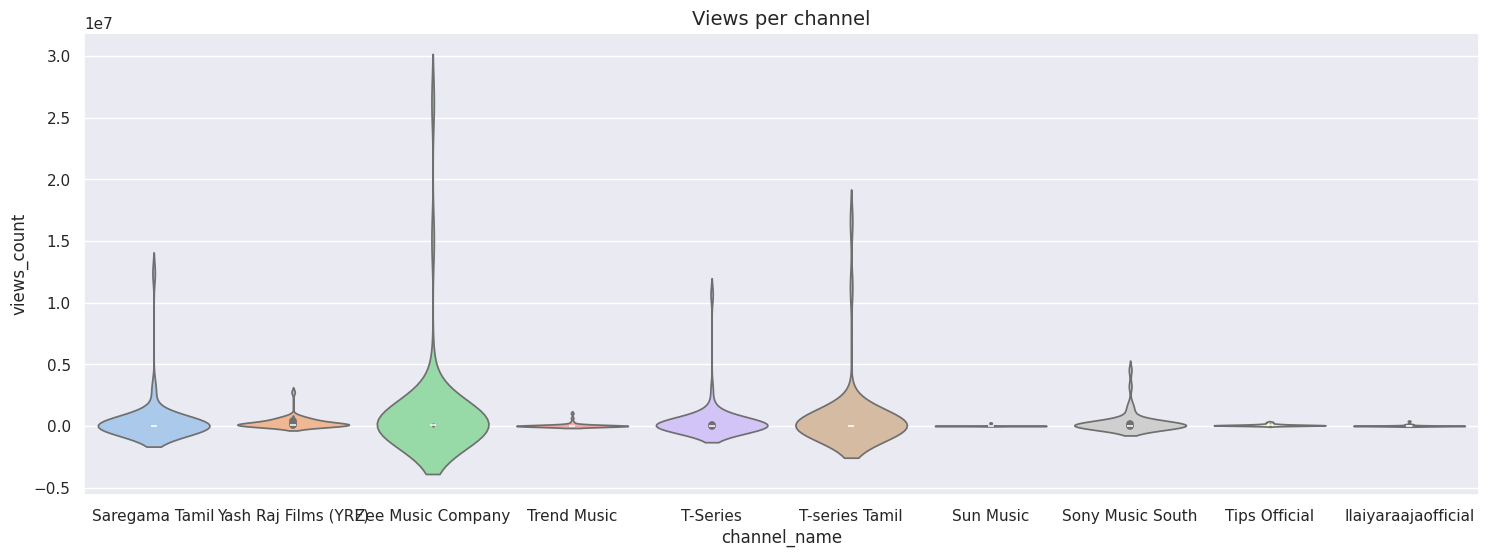

In [311]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x='channel_name', y='views_count', data=vid_pdf, palette='pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()


## Does the number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.


<Axes: xlabel='like_count', ylabel='views_count'>

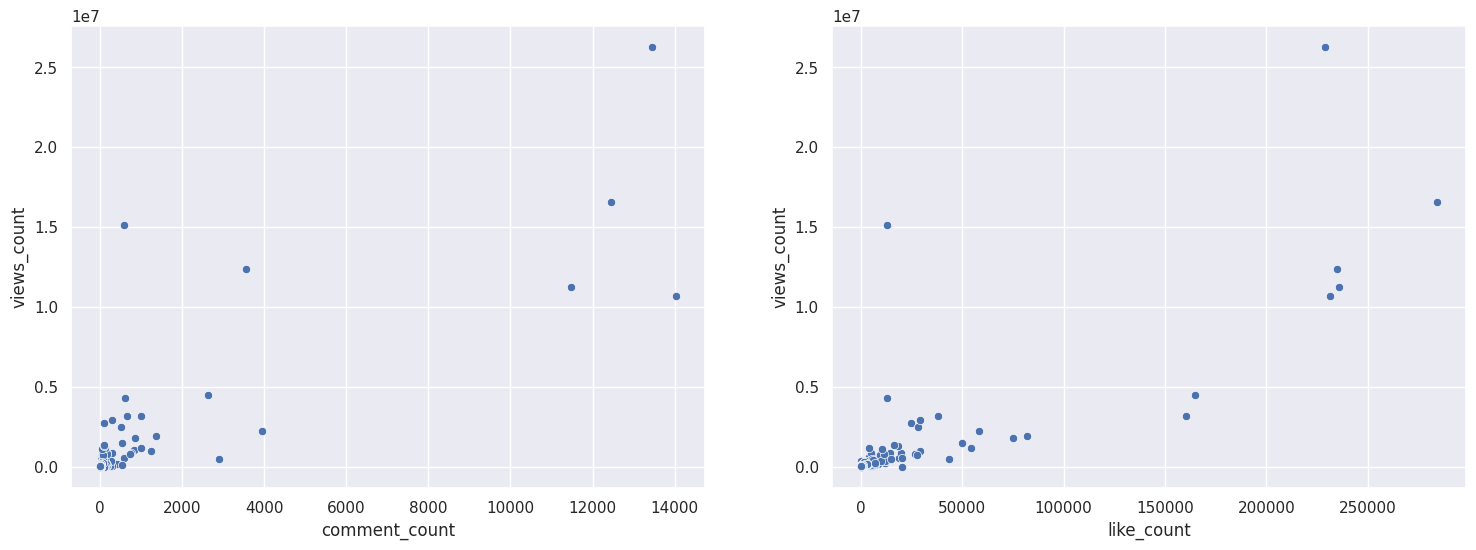

In [312]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = vid_pdf, x = "comment_count", y = "views_count", ax=ax[0])
sns.scatterplot(data = vid_pdf, x = "like_count", y = "views_count", ax=ax[1])

##### Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<Axes: xlabel='likeRatio', ylabel='views_count'>

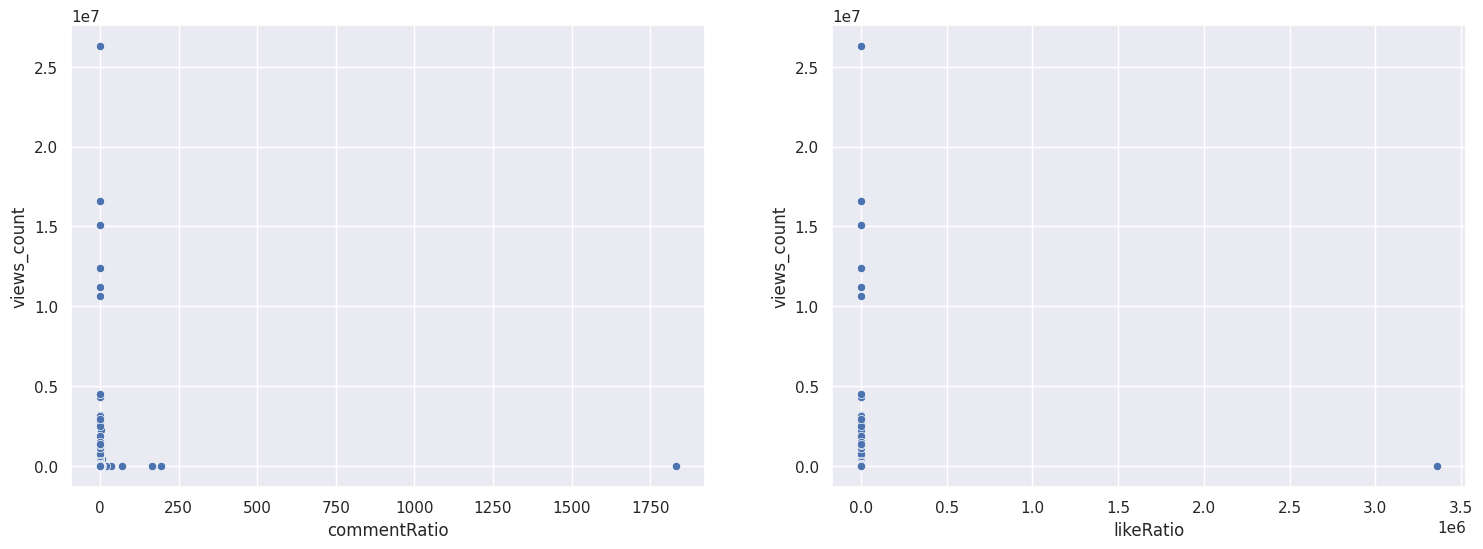

In [313]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = vid_pdf, x = "commentRatio", y = "views_count", ax=ax[0])
sns.scatterplot(data = vid_pdf, x = "likeRatio", y = "views_count", ax=ax[1])

##### 
After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some vides have very few views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, we can still see some positive correlation between views and like ratio (though very subtle), which means that the more views a video has, the more people would hit the like button! This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.


## Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 300 to 1200 seconds, which is about 5 to 20 minutes. Here I have to limit the duration to 8000 because of some really long videos (potentially streaming videos).


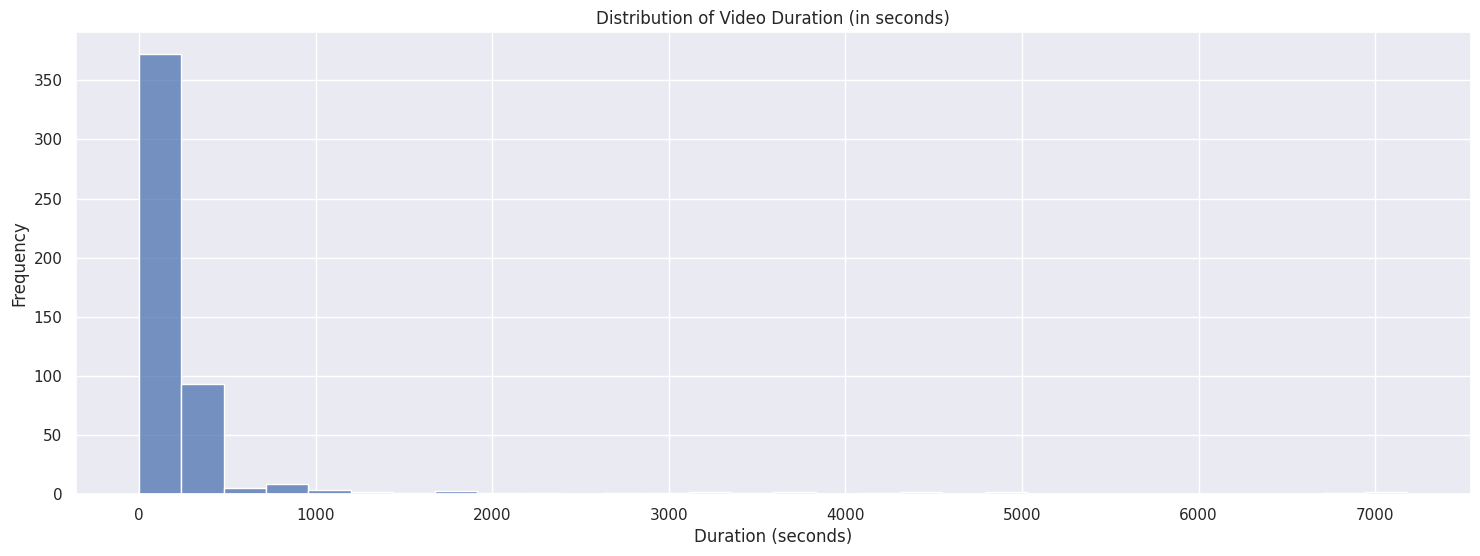

In [314]:
sns.histplot(data=vid_pdf[vid_pdf['duration_secs'] < 8000], x="duration_secs", bins=30)
plt.title("Distribution of Video Duration (in seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


##### Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

<Axes: xlabel='duration_secs', ylabel='like_count'>

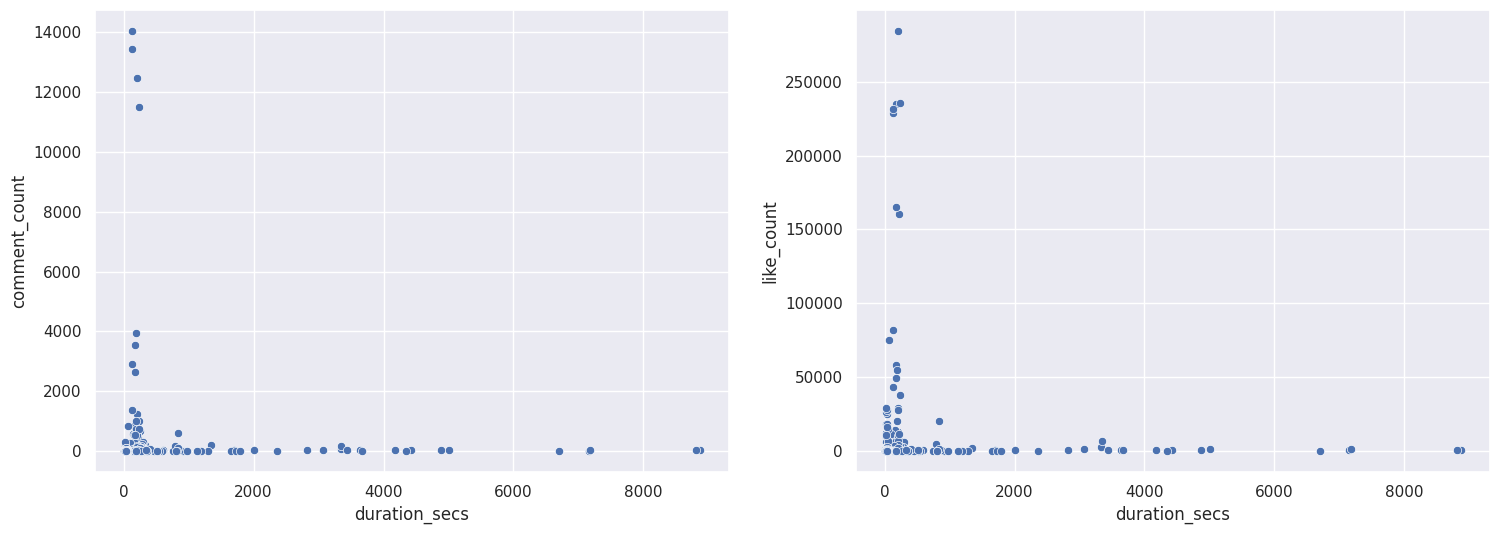

In [315]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = vid_pdf, x = "duration_secs", y = "comment_count", ax=ax[0])
sns.scatterplot(data = vid_pdf, x = "duration_secs", y = "like_count", ax=ax[1])

In [316]:
print(vid_pdf['titleLength'].mean())

85.30451866404715


### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 60 - 90 characters.


<Axes: xlabel='titleLength', ylabel='views_count'>

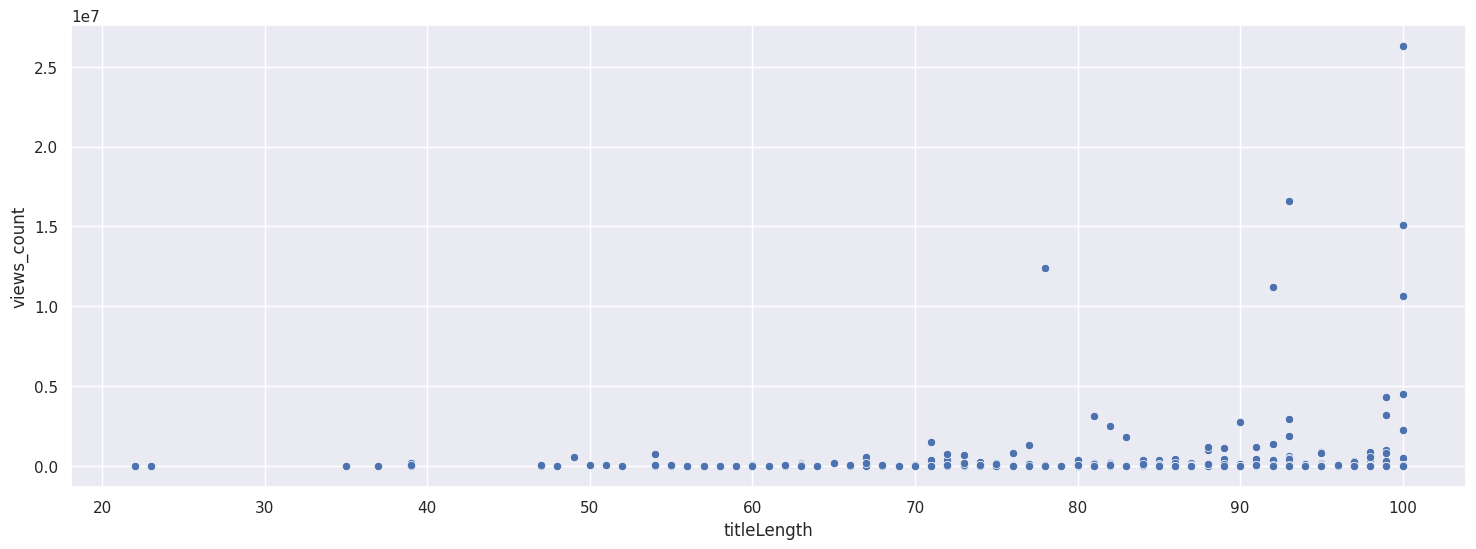

In [317]:
sns.scatterplot(data = vid_pdf, x = "titleLength", y = "views_count")

### Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words. We first need to remove the stopwords such as "you", "I", "the", etc. which do note contribute a lot to the meaning of the title.


In [318]:
stop_words = set(stopwords.words('english'))

# Remove stopwords from titles
vid_pdf['title_no_stopwords'] = vid_pdf['title'].apply(lambda x: [item for item in str(x).split() if item.lower() not in stop_words])

# Flatten list of all words
all_words = [a for b in vid_pdf['title_no_stopwords'].tolist() for a in b]
all_words_str = ' '.join(all_words)


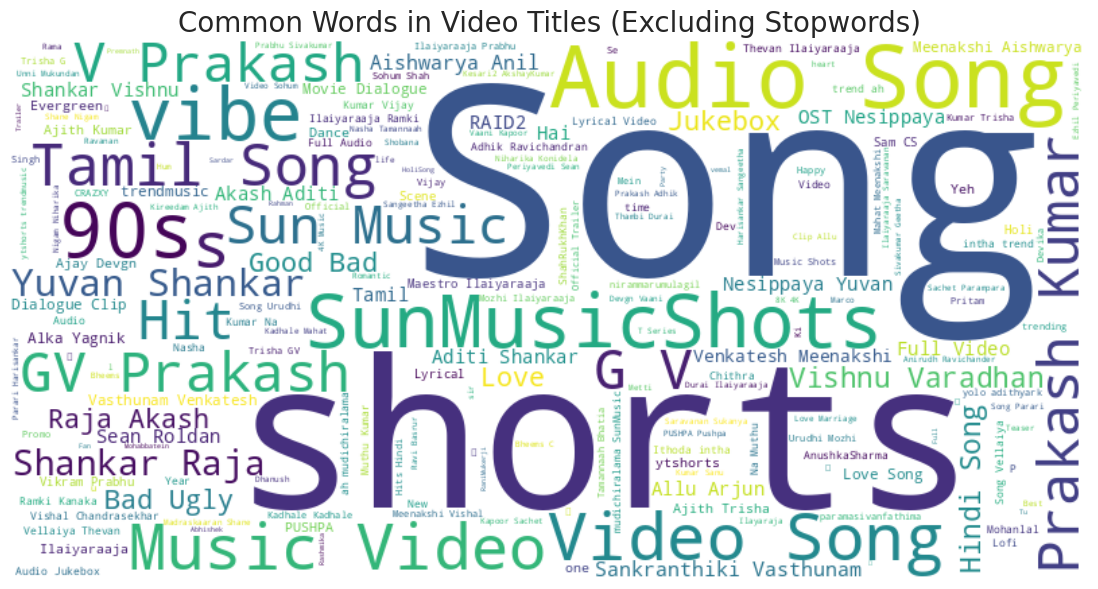

In [319]:
# Create and display the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_str)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Video Titles (Excluding Stopwords)", fontsize=20)
plt.show()


##### It can be seen that most common words are Song, shorts, Audio Song, Music Video, SunMusicShots. which is very expected.

In [320]:
print(vid_pdf['tagsCount'].mean())

19.029469548133594


### Number of tags vs views

It seems that most videos have between 15 and 35 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.



<Axes: xlabel='tagsCount', ylabel='views_count'>

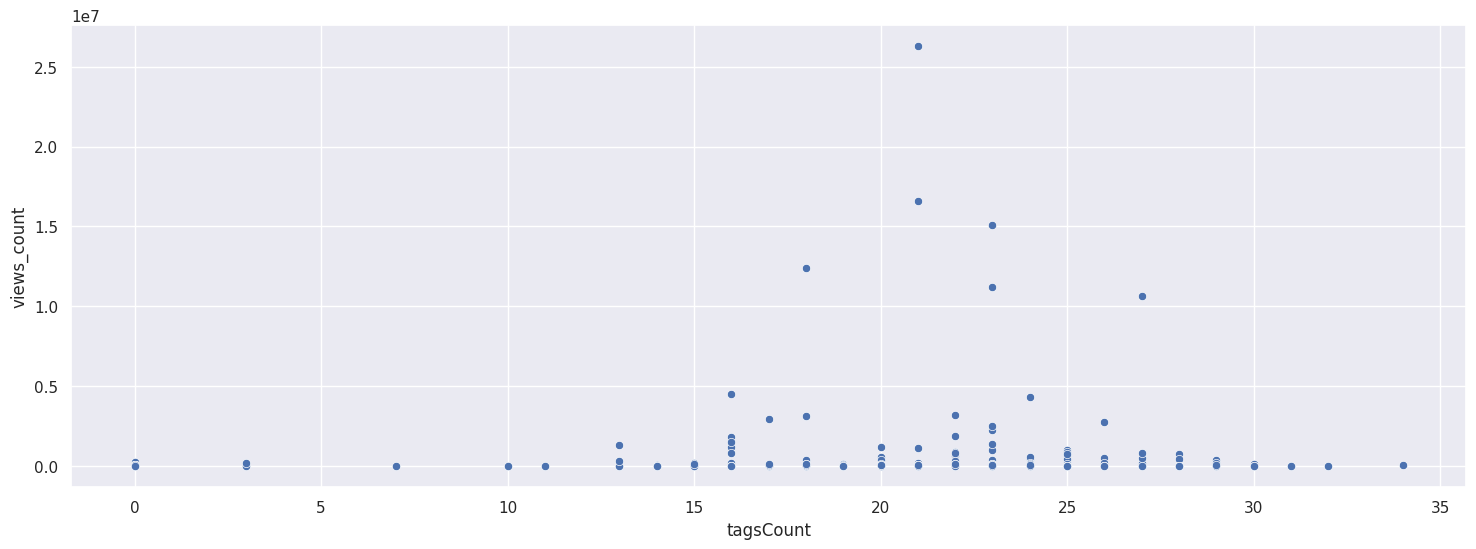

In [321]:
sns.scatterplot(data = vid_pdf, x = "tagsCount", y = "views_count")

### Which day in the week are most videos uploaded?

It's interesting to see that more videos are uploaded on Mondays and Fridays. Fewer videos are uploaded during the weekend. This could be because of the nature of the niche that is more geared towards tutorials and heavy materials, which is not suitable for weekends' consumption. But it could also just means that most creators work on their videos during the weekend or during the week and upload them beginning of the week or Friday.

In [322]:
vid_pdf.dtypes

channel_name                           object
video_id                               object
title                                  object
description                            object
tags                                   object
publish_at                             object
views_count                             int64
like_count                              int64
comment_count                           int64
video_duration                         object
comment                                object
caption                                object
definition                             object
tagsCount                               int64
publishedAt           datetime64[ns, tzutc()]
publishDayName                         object
duration_secs                         float64
likeRatio                             float64
commentRatio                          float64
titleLength                             int64
title_no_stopwords                     object
dtype: object

In [323]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = vid_pdf['publishDayName'].value_counts().reindex(weekdays).fillna(0).astype(int).reset_index()
day_df.columns = ['Day', 'Video Count']



/tmp/ipykernel_5403/3733136748.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekdays, y=day_df['Video Count'], palette='viridis')


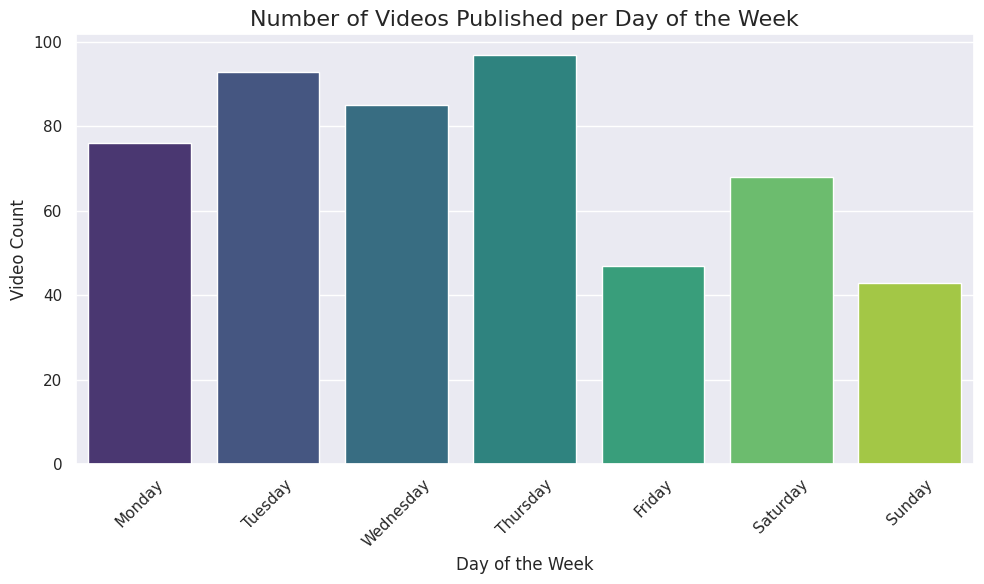

In [324]:

plt.figure(figsize=(10, 6))
sns.barplot(x=weekdays, y=day_df['Video Count'], palette='viridis')
plt.title("Number of Videos Published per Day of the Week", fontsize=16)
plt.ylabel("Video Count")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.


In [332]:
top_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comment'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

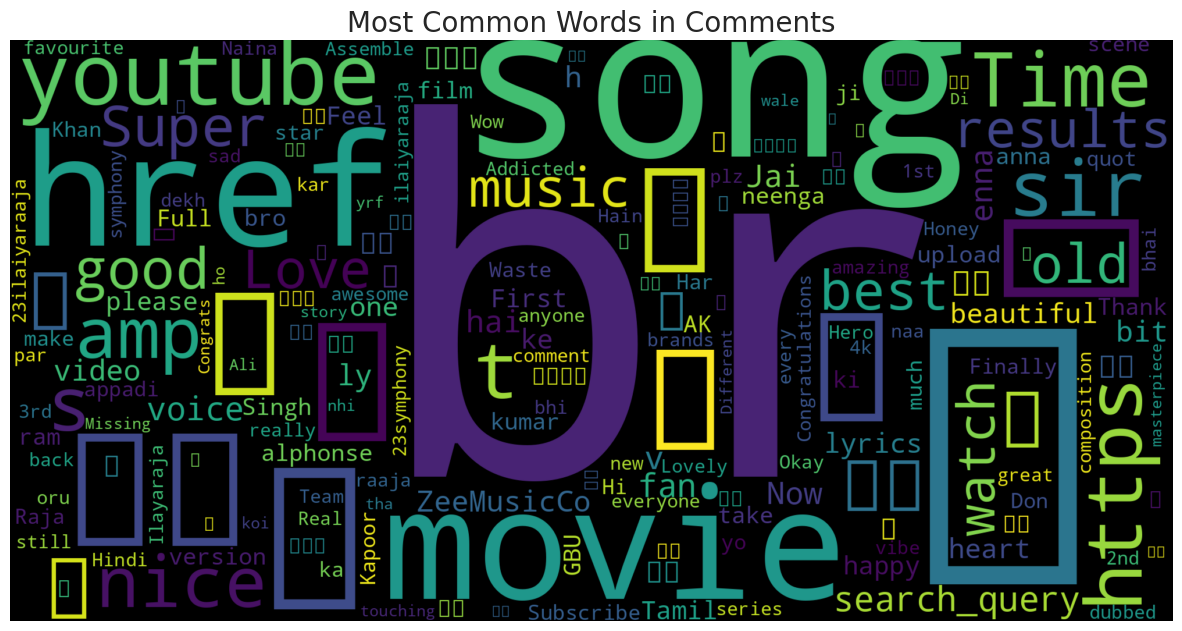

In [333]:
# Define the plot_cloud function
def plot_cloud(wordcloud):
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Most Common Words in Comments", fontsize=20)
    plt.show()

# Now you can generate and plot the word cloud
wordcloud = WordCloud(width=2000, height=1000, random_state=1, background_color='black', colormap='viridis', collocations=False
).generate(all_words_str)

plot_cloud(wordcloud)


##### We can see that next to the obvious words such as "video", "data", the most frequent words are quite positive, such as "music", "song", "good", "nice", "love".

### Conclusions and future research ideas

In this project, we have explored the video data of the 10 most popular Music channels and revealed many interesting findings for anyone who are starting out with a Youtube channel in Musics,songs,movie clips,shorts or another topic:

The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is      simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes      seem to follow the "social proof", which means the more views the video has, the more people will like it.

   1. Most videos have between 15 and 35 tags.

   2. Most-viewed videos tend to have average title length of 60 - 90 characters. Too short or too long titles seem to harm viewership.

   3. Videos are usually uploaded on Mondays to Thursday and Saturdays. Weekends and Sunday in particular is not a popular time for posting new videos.

   4. Comments on videos are generally positive, we noticed a lot "please" words, suggesting potential market gaps in content that could be filled.


### Project limitation:

The findings should also be taken with a grain of salt for a number of reasons:

  1. The number of videos is quite small (the dataset has only 700 videos)

  2. I have only considered the first 10 comments on each video, which might not be representative for all comments

  3. There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is



### Ideas for future research:

To expand and build on this research project, one can:

 1. Expand the dataset to also smaller channels in data science niche

 2. Do sentiment analysis on the comments and find out which videos get more positive comments and which videos get less positive comments

 3. Do market research by analyzing questions in the comment threads and identifying common questions/ market gaps which could potentially filled

 4. Conduct this research for other niches (e.g. vlogs or beauty channels), to compare different niches with each other to see the different patterns in viewership and video characteristics.



### References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] To know update version of Some Python Functions. ChatGpt 
 

